# Plotting Reflectivity Fits and Profiles

* **Date Created:** 2020-3-3
* **Date Modified:** 2020-3-4
* **Author:** Brian P. Josey
* **Language:** Python 3.8

In this notebook I am creating and testing functions to automatically load and plot reflectivity data, fits, and profiles from the Refl1D outputs. While that packages does it automatically, I am unhappy with the quality of the images; they come out as PNG, and the size of the data points tend to be so large that there is significant overlap between adjacent points.

**Goals:**

* Identify what data need to be plotted.
* Correctly load data into a dataframe.
* Plot the above in an aesthetically appealing plot.
* Save images in a publication quality PDF.
* Automate the process as **.py** script that can be ran from the terminal.
* Test with magnetic and non-magnetic data.

Ideally, I will also determine how to identify the name of the sample and use it in figure titles and file names.

In [1]:
# Essential libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Loading Profiles and Reflectivity

By manually inspecting the **.dat** files, it became clear that the data is delimetered by whitespace which can vary in each row. This makes the files easily readable by a human, but if I want to upload it into a dataframe using panda's **read_csv( )** functiton I need to set **delim_whitespace = True**. This has an odd effect on the header where the column names do not match with the columns; whitespace between the column name and units create additional columns of NaNs that need to be discounted. To bypass this issue, I

* Manually inspected each **.dat** file to determine what column names actually match with which column.
* Load the data into a dataframe by discounting the columns of NaNs.
* Assign the column names to the correct data label.
* I started with the profile (3 columns) before moving to the reflectometry (6 columns).

Note: the names of the data are standard for reflectometry, if a little obscure to the someone outside of the field.

In [2]:
# Profile

profile = pd.read_csv('R1XR Silicon-SiOx-profile.dat', delim_whitespace=True, usecols = ['#','z','(A)'])
profile.columns = ['z','rho','irho']
print(profile)

              z        rho      irho
0     -33.31018  20.072940  0.462067
1     -33.21018  20.073028  0.462189
2     -33.11018  20.073119  0.462314
3     -33.01018  20.073212  0.462443
4     -32.91018  20.073308  0.462575
...         ...        ...       ...
2622  228.88982   0.259190  0.016260
2623  228.98982   0.237525  0.014901
2624  229.08982   0.217521  0.013646
2625  229.18982   0.199063  0.012488
2626  229.28982   0.182046  0.011421

[2627 rows x 3 columns]


In [3]:
# Reflectivity

refl = pd.read_csv('R1XR Silicon-SiOx-refl.dat', delim_whitespace=True, header = 2, usecols=[
    '#','Q','(1/A)','dQ', '(1/A).1', 'R'
    ])

refl.columns = ['Q','dQ','R','dR','theory','fresnel']
print(refl)

            Q        dQ             R            dR        theory  \
0    0.048364  0.000751  9.514346e-01  5.010035e-03  9.185497e-01   
1    0.049787  0.000751  9.404456e-01  4.966974e-03  9.148689e-01   
2    0.051209  0.000751  9.248359e-01  4.905727e-03  9.085837e-01   
3    0.052632  0.000751  9.150795e-01  4.867396e-03  9.011532e-01   
4    0.054054  0.000751  8.916430e-01  4.775170e-03  8.924725e-01   
..        ...       ...           ...           ...           ...   
368  0.778334  0.000777  6.195594e-09  6.168920e-09  6.087096e-09   
369  0.781166  0.000778  5.519778e-09  6.187505e-09  5.579134e-09   
370  0.783998  0.000778 -4.483326e-09  5.966852e-09  4.655729e-09   
371  0.786830  0.000778 -3.221620e-09  5.954848e-09  3.504905e-09   
372  0.789661  0.000778  9.079601e-09  6.148678e-09  2.577275e-09   

          fresnel  
0    1.886262e-02  
1    1.722882e-02  
2    1.498312e-02  
3    1.303783e-02  
4    1.141158e-02  
..            ...  
368  1.771692e-07  
369  1.7461

## Plotting the Data

Now that I have the data, I want to plot it. For the profiles, I want to plot both **rho** and **irho** as functions of **z** on the same plot with linear axes. For reflectometry, I need **R**, **dR**, and the fit all as functions of **Q** on a semilog (y-axis) plot.

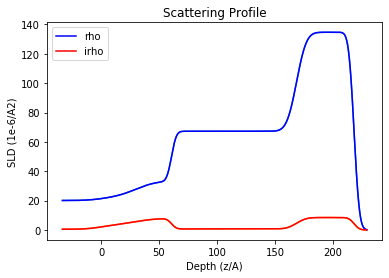

In [4]:
# Fitted Profile

fig, ax = plt.subplots()
ax.plot(profile.z, profile.rho, profile.z, profile.irho)
plt.rcParams["figure.figsize"] = (12, 9)

ax.set(xlabel = 'Depth (z/A)', ylabel = 'SLD (1e-6/A2)', title = 'Scattering Profile')

plt.plot(profile.z, profile.rho, "-b", label="rho")
plt.plot(profile.z, profile.irho, "-r", label="irho")
plt.legend(loc="upper left")


plt.show()
fig.savefig("Profile.pdf")

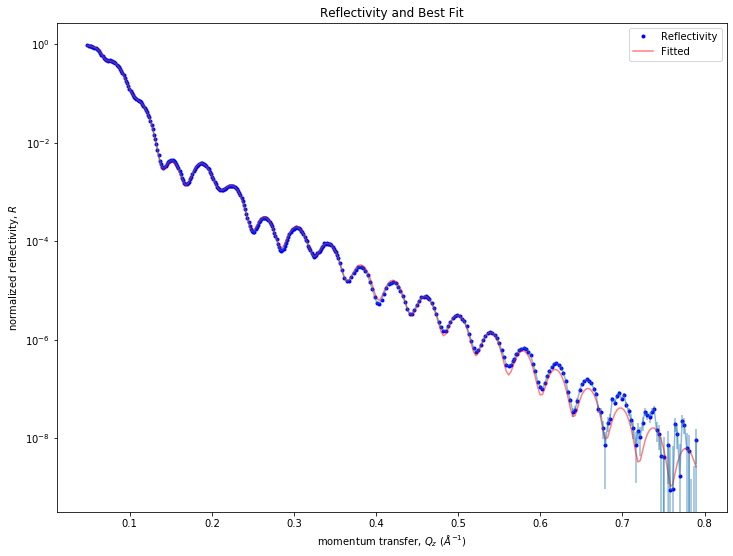

In [5]:
# Plotting Reflectometry
fig, ax = plt.subplots()

plt.plot(refl.Q, refl.R, ".b", label = "Reflectivity", alpha = 1)
plt.plot(refl.Q, refl.theory, "-r", label = "Fitted", alpha = 0.5)
plt.legend(loc="upper right")

ax.errorbar(refl.Q, refl.R, yerr=refl.dR, fmt='-', alpha =0.5)
ax.set(xlabel=r"momentum transfer, $Q_{z}\ (Å^{-1})$", ylabel=r"normalized reflectivity, $R$",
       title="Reflectivity and Best Fit")
ax.semilogy()

plt.show()
fig.savefig("Reflectivity.pdf")

## Magnetic Samples

The code above works well for X-ray reflectivity data because it is relatively simple: experiments give single reflectivity curves that are modeled with profiles that only have **rho** and **irho**. With the addition of magnetic polarization each experiment returns two reflectivity curves ("up-up" and "down-down") and the profile needs the addition of the magnetic angle and scattering length density while **irho** is ignored. An interesting result of this is that the reflectivity file is saved in two files: "up-up" ends in **.datA**, and "down-down" ends in **.datD**.

In [10]:
# Loading the Profile- IGNORE IRHO!

mag_profile = pd.read_csv("R1_Ar-profile.dat", delim_whitespace=True, usecols=["#", "z", "rho", "(1e-6/A2)"])
mag_profile.columns = ["z", "rho", "rhoM", "theta"]
print(mag_profile)

               z       rho  rhoM  theta
0     -77.091836  2.071001   0.0    0.0
1     -76.991836  2.071001   0.0    0.0
2     -76.891836  2.071001   0.0    0.0
3     -76.791836  2.071001   0.0    0.0
4     -76.691836  2.071001   0.0    0.0
...          ...       ...   ...    ...
5975  520.408164  0.006256   0.0    0.0
5976  520.508164  0.006033   0.0    0.0
5977  520.608164  0.005817   0.0    0.0
5978  520.708164  0.005608   0.0    0.0
5979  520.808164  0.005406   0.0    0.0

[5980 rows x 4 columns]


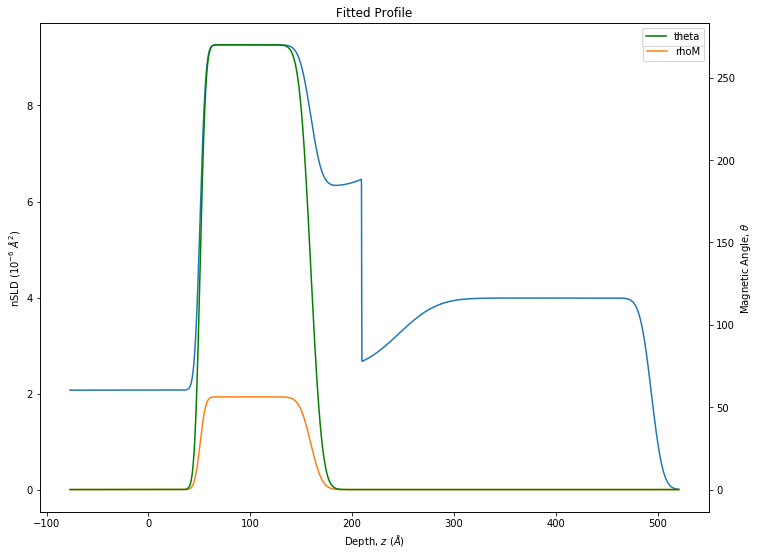

In [29]:
# Fitted Profile
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(mag_profile.z, mag_profile.rho, label = "rho")
ax1.plot(mag_profile.z, mag_profile.rhoM, label="rhoM")
ax2.plot(mag_profile.z, mag_profile.theta, "-g", label="theta")

ax1.set_xlabel(r"Depth, $z$ ($\AA$)")
ax1.set_ylabel(r"nSLD ($10^{-6}\ \AA^{2}$)")
ax2.set_ylabel(r"Magnetic Angle, $\theta$")
ax1.set_title("Fitted Profile")

ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
plt.show()
fig.savefig("Mag_Profile.pdf")

In [34]:
# Load Reflectivity Data for Magnetic

mag_reflA = pd.read_csv("R1_Ar-refl.datA", delim_whitespace=True, header = 2, usecols=[
    '#','Q','(1/A)','dQ', '(1/A).1', 'R'
    ])
mag_reflA.columns = ['Q','dQ','R','dR','theory','fresnel']
print(mag_reflA)

mag_reflD = pd.read_csv("R1_Ar-refl.datD", delim_whitespace=True, header = 2, usecols=[
    '#','Q','(1/A)','dQ', '(1/A).1', 'R'
    ])
mag_reflD.columns = ['Q','dQ','R','dR','theory','fresnel']
print(mag_reflD)

            Q        dQ             R            dR        theory  \
0    0.010098  0.000089  9.654059e-01  1.026374e-02  9.993282e-01   
1    0.010541  0.000093  9.475393e-01  1.009076e-02  9.918003e-01   
2    0.010975  0.000096  9.407264e-01  1.003114e-02  9.850562e-01   
3    0.011414  0.000099  9.431969e-01  1.001464e-02  9.777091e-01   
4    0.011852  0.000102  9.271439e-01  9.911282e-03  9.689133e-01   
..        ...       ...           ...           ...           ...   
338  0.412214  0.003380 -3.544884e-08  2.128842e-07  1.168208e-07   
339  0.413945  0.003392  7.252131e-08  2.278454e-07  1.201968e-07   
340  0.415675  0.003404  1.419194e-08  2.217592e-07  1.217759e-07   
341  0.417406  0.003417  4.775724e-07  2.586272e-07  1.221666e-07   
342  0.419136  0.003429 -1.991428e-07  1.798892e-07  1.219274e-07   

          fresnel  
0    8.965924e-01  
1    3.994058e-01  
2    2.198709e-01  
3    1.477403e-01  
4    1.072397e-01  
..            ...  
338  2.352569e-08  
339  2.3195

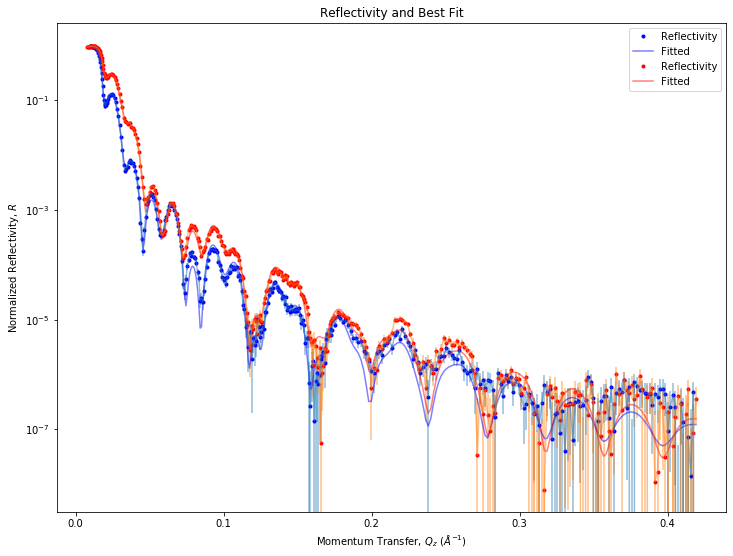

In [40]:
# Plotting Reflectometry
fig, ax = plt.subplots()

plt.plot(mag_reflA.Q, mag_reflA.R, ".b", label = "Reflectivity", alpha = 1)
plt.plot(mag_reflA.Q, mag_reflA.theory, "-b", label = "Fitted", alpha = 0.5)
plt.plot(mag_reflD.Q, mag_reflD.R, ".r", label = "Reflectivity", alpha = 1)
plt.plot(mag_reflD.Q, mag_reflD.theory, "-r", label = "Fitted", alpha = 0.5)

plt.legend(loc="upper right")

ax.errorbar(mag_reflA.Q, mag_reflA.R, yerr=mag_reflA.dR, fmt='-', alpha =0.5)
ax.errorbar(mag_reflD.Q, mag_reflD.R, yerr=mag_reflD.dR, fmt='-', alpha =0.5)
ax.set(xlabel=r"Momentum Transfer, $Q_{z}\ (Å^{-1})$", ylabel=r"Normalized Reflectivity, $R$",
       title="Reflectivity and Best Fit")
ax.semilogy()

plt.show()
fig.savefig("Mag_Reflectivity.pdf")

## Current Status/Next Steps

I can now load and plot any set of reflectivity curves and profiles. I am happy with the results for the most part, but I want to improve the configurations of the plots and fix the legend on the magnetic profile. The next steps are

* Fix the overlapping legends on the magnetic profile figure.
* Improve the readability of the plots, especially the axis labels.
* Create functions that automate loading, plotting, and saving the data.
* Test these function in a systematic matter.
* Automatically extract the filenames from the folder to use as a variable.
* Create a test for magnetic, non-magnetic, and X-ray reflectivity curves.
* Export everything into a **.py** file that can be ran directly from the command line.

That's it for today, and I'll come back tomorrow.